In [1]:
!pip install statsmodels

In [2]:
#importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates
from datetime import datetime

In [3]:
df=pd.read_csv('AirPassengers.csv')
df.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

In [4]:
#Convert Month object into datetime
df['Month'] = pd.to_datetime(df.Month)
df = df.set_index(df.Month)
df.drop('Month', axis = 1, inplace = True)
df.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [5]:
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

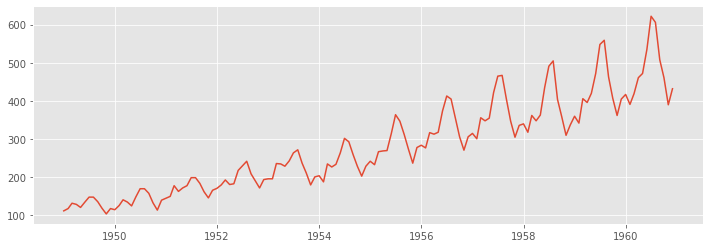

In [6]:
#fluctuation of customer traffic within october
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,4)
plt.plot(ts)
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary
# A function defined for Dickey Fuller Test
def adfuller_test(births):
    result=adfuller(births)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.1:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [8]:
#dickey fuller test for ts
adfuller_test(ts)

ADF Test Statistic : 0.8153688792060544
p-value : 0.9918802434376411
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


***Since there is a significant positive trend,we can apply log transformation to penalize higher values more than smaller values.***

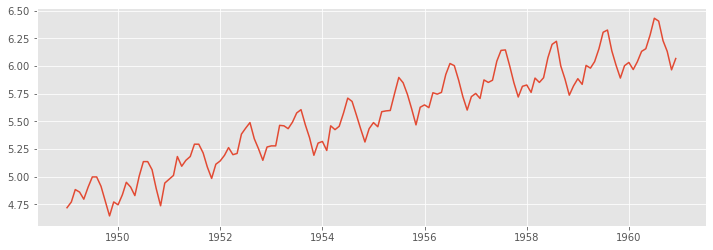

In [9]:
#Taking a log transform
ts_log = np.log(ts)
plt.plot(ts_log)

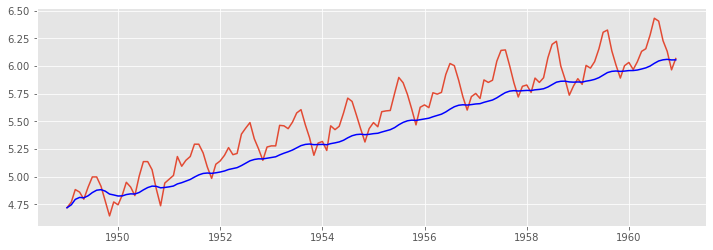

In [10]:
#Exponentially weighted average to smoothen out the curve
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'blue')

In [11]:
#Getting the residual so as to understand whether exponentially weighted average could understand the trend or not
#by performing dickey fuller test
ts_log_ewm_diff = ts_log - exp_weighted_avg
adfuller_test(ts_log_ewm_diff)

ADF Test Statistic : -3.601262420161675
p-value : 0.0057369388015119215
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


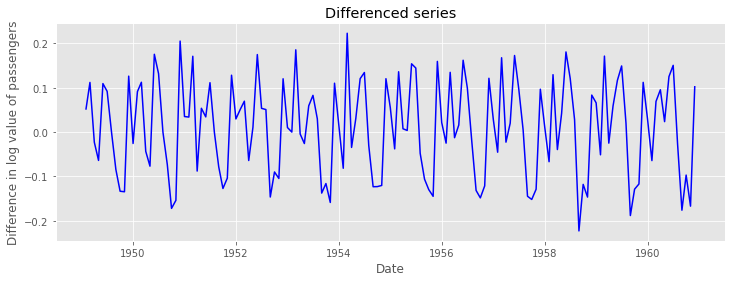

In [12]:
#a one shift difference for ts_log just as an attempt to check another stationarity
from statsmodels.tsa.statespace.tools import diff
fig = plt.figure(figsize=(12,4))
plt.plot(diff(ts_log),color='b');
plt.xlabel('Date')
plt.ylabel('Difference in log value of passengers')
plt.title('Differenced series')
plt.show()

In [13]:
#Dickey Fuller test for one shift
adfuller_test(diff(ts_log))

ADF Test Statistic : -2.7171305983881595
p-value : 0.07112054815085424
#Lags Used : 14
Number of Observations Used : 128
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


/Users/liguanghui/opt/anaconda3/envs/py37-pytorch/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


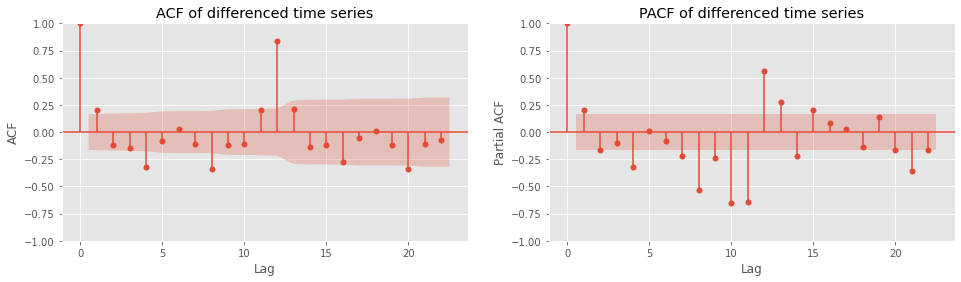

In [14]:
#plot PACF and ACF to obtain orders of AR and MA values.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1)
plot_acf(diff(ts_log), title='ACF of differenced time series',ax=ax1 )
plt.xlabel('Lag')
plt.ylabel('ACF')
ax2 = plt.subplot(1,2,2)
plot_pacf(diff(ts_log), title='PACF of differenced time series',ax=ax2)
plt.xlabel('Lag')
plt.ylabel('Partial ACF')
plt.show()

### Using widely used difference operation and hence We can think of three cases taking AR(1) or MA(1) or ARIMA(1,1,1)

In [15]:
#Analysing MA(1) Model and plotting its graph 

import statsmodels.api as sm


from statsmodels.tsa.arima_model import ARIMA
model1 = sm.tsa.arima.ARIMA(ts_log, order=(0,1,1))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())
residuals = pd.DataFrame(model1_fit.resid)
model1_sse = sum((residuals**2).values)
model1_aic = model1_fit.aic
plt.plot(diff(ts_log))
plt.plot(model1_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model1_sse )

/Users/liguanghui/opt/anaconda3/envs/py37-pytorch/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/liguanghui/opt/anaconda3/envs/py37-pytorch/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/liguanghui/opt/anaconda3/envs/py37-pytorch/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


TypeError: fit() got an unexpected keyword argument 'disp'

In [52]:
#Analysing AR(1) Model and plotting its graph 
model2 = ARIMA(ts_log, order=(1,1,0))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())
residuals = pd.DataFrame(model2_fit.resid)
model2_sse = sum((residuals**2).values)
model2_aic = model2_fit.aic
plt.plot(diff(ts_log))
plt.plot(model2_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model2_sse )

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [16]:
#Analysing ARIMA(1,1,1) Model and plotting its graph 
model3 = ARIMA(ts_log, order=(1,1,1))
model3_fit = model3.fit(disp=0)
print(model3_fit.summary())
residuals = pd.DataFrame(model3_fit.resid)
model3_sse = sum((residuals**2).values)
model3_aic = model3_fit.aic
plt.plot(diff(ts_log))
plt.plot(model3_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model3_sse )

NameError: name 'ARIMA' is not defined

In [17]:
#Analysing ARIMA(2,1,2) Model and plotting its graph 
model4 = ARIMA(ts_log, order=(2,1,2))
model4_fit = model4.fit(disp=0)
print(model4_fit.summary())
residuals = pd.DataFrame(model4_fit.resid)
model4_sse = sum((residuals**2).values)
model4_aic = model4_fit.aic
plt.plot(diff(ts_log))
plt.plot(model4_fit.fittedvalues, color = 'blue')
plt.title('RSS: %.4f'% model4_sse )

NameError: name 'ARIMA' is not defined

In [18]:
#Analysing AIC and SSE of all 4 models
results_df = pd.DataFrame({
    'Arima(0,1,1)': [model1_aic, "{:.3f}".format(model1_sse[0])], 
    'Arima(1,1,0)': [model2_aic, "{:.3f}".format(model2_sse[0])],
    'Arima(1,1,1)': [model3_aic, "{:.3f}".format(model3_sse[0])],
    'Arima(2,1,2)': [model4_aic, "{:.3f}".format(model4_sse[0])]
}, index=['AIC', 'SSE'])

results_df.head()

NameError: name 'model1_aic' is not defined

### Predictions by my best model which is ARIMA(2,1,2)

In [19]:
predictions_diff_log = pd.Series(model4_fit.fittedvalues, copy=True)
print("The predicted log residuals are like this")
print(predictions_diff_log.head())
print("Predictions similar to what we had before taking residuals of log")
predictions_diff_log_cumsum = predictions_diff_log.cumsum()
predictions_diff_log_cumsum.head()

NameError: name 'model4_fit' is not defined

In [20]:
#The first value which was subtracted in log operation
pd.Series(ts_log.iloc[0], index=ts_log.index).head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [29]:
#The predictions just after the log operation took place resemble values like these
predictions_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_log = predictions_log.add(predictions_diff_log_cumsum,fill_value=0)
print('The predictions just after the log operation took place resemble values like these')
predictions_log.head()

The predictions just after the log operation took place resemble values like these


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1046')

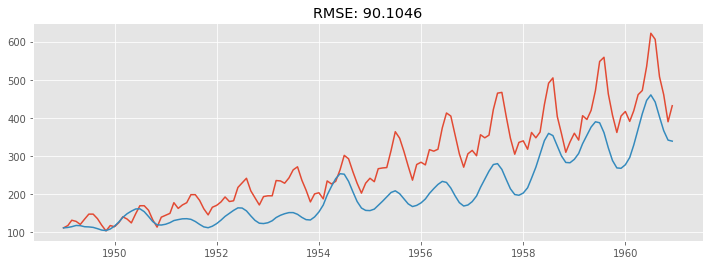

In [30]:
#Since I applied log operation before differencing, its effect had to be restored so exponents had to be taken
predictions_ARIMA = np.exp(predictions_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

### Now Prediction isn't nice, something seems to be missing and we can easily see a seasonal characteristic which we didn't encounter earlier.

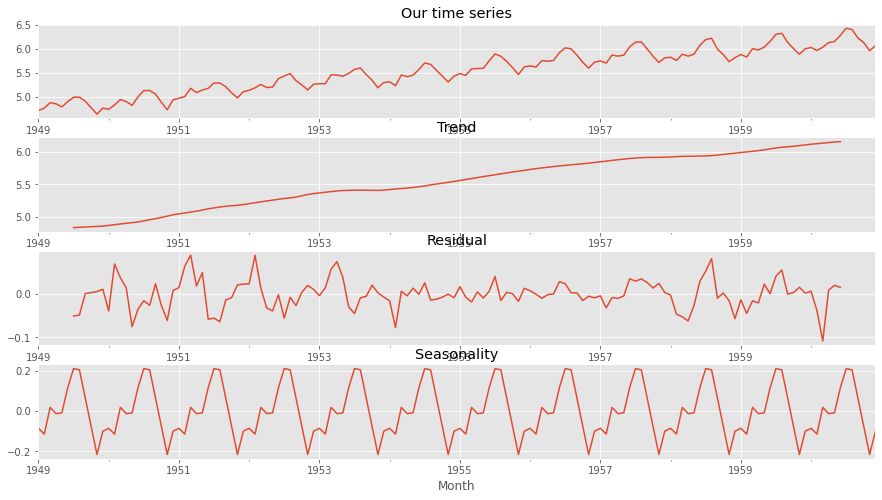

In [31]:
# Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose# Decompose time series into daily trend, seasonal, and residual components.
decomp = seasonal_decompose(ts_log, model = 'additive')# Plot the decomposed time series to interpret.
fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8));
decomp.observed.plot(ax=ax0, title='Our time series');
decomp.trend.plot(ax=ax1, title='Trend');
decomp.resid.plot(ax=ax2, title='Residual');
decomp.seasonal.plot(ax=ax3, title='Seasonality');

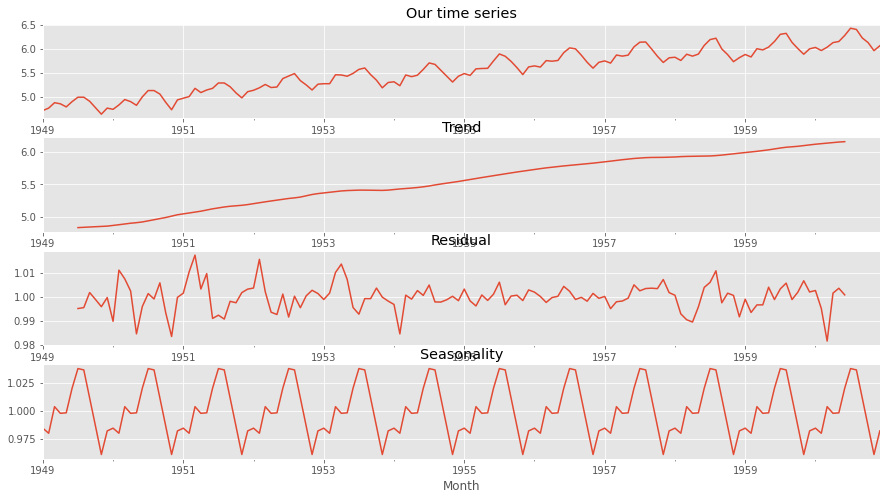

In [32]:
# Multiplicative Decomposition
decomp = seasonal_decompose(ts_log, model = 'multiplicative')# Plot the decomposed time series to interpret.
fig, (ax0, ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8));
decomp.observed.plot(ax=ax0, title='Our time series');
decomp.trend.plot(ax=ax1, title='Trend');
decomp.resid.plot(ax=ax2, title='Residual');
decomp.seasonal.plot(ax=ax3, title='Seasonality');

## SARIMA

In [16]:
import itertools
q = [1,2]
p = [1,2]
d = [0,1]
pdq = list(itertools.product(p, d, q))
print(pdq)
#Generate all different combinations of seasonal p, q and q triplet
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

[(1, 0, 1), (1, 0, 2), (1, 1, 1), (1, 1, 2), (2, 0, 1), (2, 0, 2), (2, 1, 1), (2, 1, 2)]
[(1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 1, 12), (1, 1, 2, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 1, 12), (2, 1, 2, 12)]


In [17]:
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (1, 0, 2) x (1, 0, 2, 12)
SARIMAX: (1, 0, 2) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 2, 12)
SARIMAX: (1, 1, 1) x (2, 0, 1, 12)


In [18]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")           #Specify to ignore warning messages
AIC_df = pd.DataFrame({}, columns = ['param', 'param_seasonal', 'AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_log, order = param, seasonal_order = param_seasonal, 
            enforce_stationarity = False, enforce_invertibility = False)
            results = mod.fit()
            temp = pd.DataFrame([[param, param_seasonal, results.aic]], columns = ['param', 'param_seasonal', 'AIC'])
            AIC_df = AIC_df.append(temp, ignore_index = True)
            del temp
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11604D+00    |proj g|=  6.86654D+00

At iterate    5    f= -1.50116D+00    |proj g|=  3.53677D+00

At iterate   10    f= -1.56139D+00    |proj g|=  5.54026D+00

At iterate   15    f= -1.68069D+00    |proj g|=  1.71416D+00

At iterate   20    f= -1.68597D+00    |proj g|=  4.83145D-01

At iterate   25    f= -1.69197D+00    |proj g|=  3.55392D-01

At iterate   30    f= -1.69248D+00    |proj g|=  1.31923D-01

At iterate   35    f= -1.69312D+00    |proj g|=  1.83966D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     59      1     0     0   8.216D-04  -1.693D+00
  F =  -1.6931228628013615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.92986D-01    |proj g|=  5.88488D+00

At iterate    5    f= -1.29034D+00    |proj g|=  2.29440D+00


 This problem is unconstrained.



At iterate   10    f= -1.36540D+00    |proj g|=  4.67409D+00

At iterate   15    f= -1.49078D+00    |proj g|=  3.49168D+00

At iterate   20    f= -1.50973D+00    |proj g|=  6.60684D-01

At iterate   25    f= -1.51626D+00    |proj g|=  2.77729D-01

At iterate   30    f= -1.52488D+00    |proj g|=  1.41017D+00

At iterate   35    f= -1.53121D+00    |proj g|=  3.42877D-03

At iterate   40    f= -1.53121D+00    |proj g|=  5.36494D-02

At iterate   45    f= -1.53121D+00    |proj g|=  4.66894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     67      1     0     0   4.733D-03  -1.531D+00
  F =  -1.53121284854

 This problem is unconstrained.



At iterate   15    f= -1.47313D+00    |proj g|=  2.20470D-01

At iterate   20    f= -1.48763D+00    |proj g|=  2.84426D+00

At iterate   25    f= -1.52153D+00    |proj g|=  1.27889D-01

At iterate   30    f= -1.53320D+00    |proj g|=  7.13986D-02

At iterate   35    f= -1.53324D+00    |proj g|=  3.41128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   3.411D-04  -1.533D+00
  F =  -1.5332367364393895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f= -1.39152D+00    |proj g|=  5.25504D-01

At iterate   10    f= -1.39455D+00    |proj g|=  2.38790D-01

At iterate   15    f= -1.39466D+00    |proj g|=  1.01339D-01

At iterate   20    f= -1.39581D+00    |proj g|=  1.00931D-01

At iterate   25    f= -1.39743D+00    |proj g|=  9.17984D-01

At iterate   30    f= -1.40361D+00    |proj g|=  7.57059D-02

At iterate   35    f= -1.42412D+00    |proj g|=  7.19607D-02

At iterate   40    f= -1.42495D+00    |proj g|=  2.90156D-01

At iterate   45    f= -1.42511D+00    |proj g|=  5.54251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     72   

 This problem is unconstrained.



At iterate    5    f= -1.36458D+00    |proj g|=  7.61423D-01

At iterate   10    f= -1.44469D+00    |proj g|=  3.71900D+00

At iterate   15    f= -1.53247D+00    |proj g|=  2.22415D+00

At iterate   20    f= -1.54586D+00    |proj g|=  1.05503D+00

At iterate   25    f= -1.55041D+00    |proj g|=  6.85226D-03

At iterate   30    f= -1.55051D+00    |proj g|=  1.41141D-01

At iterate   35    f= -1.55102D+00    |proj g|=  4.28669D-02

At iterate   40    f= -1.55102D+00    |proj g|=  1.23518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     65      1     0     0   1.235D-03  -1.551D+00
  F =  -1.55101883854

 This problem is unconstrained.



At iterate    5    f= -1.30844D+00    |proj g|=  1.35262D+00

At iterate   10    f= -1.54243D+00    |proj g|=  4.78813D-01

At iterate   15    f= -1.54654D+00    |proj g|=  3.11851D-01

At iterate   20    f= -1.54791D+00    |proj g|=  9.39458D-02

At iterate   25    f= -1.54961D+00    |proj g|=  1.09543D+00

At iterate   30    f= -1.55036D+00    |proj g|=  1.42463D-01

At iterate   35    f= -1.55061D+00    |proj g|=  4.11188D-01

At iterate   40    f= -1.56284D+00    |proj g|=  2.23587D+00

At iterate   45    f= -1.56905D+00    |proj g|=  3.53536D-01

At iterate   50    f= -1.57085D+00    |proj g|=  2.20923D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.29204D+00    |proj g|=  4.78945D-01

At iterate   10    f= -1.35350D+00    |proj g|=  6.63942D+00

At iterate   15    f= -1.40481D+00    |proj g|=  6.49701D-01

At iterate   20    f= -1.40600D+00    |proj g|=  1.04409D+00

At iterate   25    f= -1.41419D+00    |proj g|=  6.24217D-02

At iterate   30    f= -1.41445D+00    |proj g|=  2.90194D-01

At iterate   35    f= -1.42080D+00    |proj g|=  3.72419D-01

At iterate   40    f= -1.42403D+00    |proj g|=  2.41934D-02

At iterate   45    f= -1.42430D+00    |proj g|=  5.33802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     60   

 This problem is unconstrained.



At iterate    5    f= -1.31183D+00    |proj g|=  1.11377D+00

At iterate   10    f= -1.33276D+00    |proj g|=  3.09738D+00

At iterate   15    f= -1.33774D+00    |proj g|=  8.07568D-02

At iterate   20    f= -1.34427D+00    |proj g|=  1.65869D+00

At iterate   25    f= -1.36349D+00    |proj g|=  4.39451D-01

At iterate   30    f= -1.37397D+00    |proj g|=  7.93060D-01

At iterate   35    f= -1.40300D+00    |proj g|=  1.25846D+00

At iterate   40    f= -1.41266D+00    |proj g|=  1.56205D+00

At iterate   45    f= -1.41719D+00    |proj g|=  1.58087D-02

At iterate   50    f= -1.41719D+00    |proj g|=  2.35874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f= -1.65941D+00    |proj g|=  1.56880D+00

At iterate   25    f= -1.67542D+00    |proj g|=  1.15845D-01

At iterate   30    f= -1.67757D+00    |proj g|=  7.59035D-02

At iterate   35    f= -1.67758D+00    |proj g|=  3.93005D-02

At iterate   40    f= -1.67761D+00    |proj g|=  3.38933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     66      1     0     0   3.066D-03  -1.678D+00
  F =  -1.6776069783173098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.78003D-01    |proj g|=  5.79737D+00

At iterate    5    f= -1.28647D+00    |proj g|=  2.44427D+00

At iterate   10    f= -1.41264D+00    |proj g|=  4.48870D+00

At iterate   15    f= -1.43445D+00    |proj g|=  1.97715D+00

At iterate   20    f= -1.46443D+00    |proj g|=  4.62801D-01

At iterate   25    f= -1.51088D+00    |proj g|=  3.86629D-01

At iterate   30    f= -1.51330D+00    |proj g|=  2.61766D-01

At iterate   35    f= -1.52250D+00    |proj g|=  2.79940D-01

At iterate   40    f= -1.52267D+00    |proj g|=  1.16654D-01

At iterate   45    f= -1.52317D+00    |proj g|=  1.96182D-01

At iterate   50    f= -1.52320D+00    |proj g|=  4.44604D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f= -1.46029D+00    |proj g|=  4.48181D-01

At iterate   20    f= -1.46219D+00    |proj g|=  7.04671D-01

At iterate   25    f= -1.47510D+00    |proj g|=  1.22825D-01

At iterate   30    f= -1.52101D+00    |proj g|=  2.13821D-01

At iterate   35    f= -1.52199D+00    |proj g|=  1.55114D-02

At iterate   40    f= -1.52200D+00    |proj g|=  1.53036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     51      1     0     0   1.530D-04  -1.522D+00
  F =  -1.5219965837703220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f= -1.38786D+00    |proj g|=  6.14740D-01

At iterate   10    f= -1.39164D+00    |proj g|=  8.74862D-01

At iterate   15    f= -1.39322D+00    |proj g|=  6.11128D-02

At iterate   20    f= -1.39459D+00    |proj g|=  1.89810D-02

At iterate   25    f= -1.39497D+00    |proj g|=  5.82349D-01

At iterate   30    f= -1.40842D+00    |proj g|=  1.15636D+00

At iterate   35    f= -1.41500D+00    |proj g|=  2.70019D-01

At iterate   40    f= -1.41691D+00    |proj g|=  4.42968D-01

At iterate   45    f= -1.41801D+00    |proj g|=  2.48002D-01

At iterate   50    f= -1.42396D+00    |proj g|=  1.48821D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -1.48655D+00    |proj g|=  3.67423D+00

At iterate   15    f= -1.52204D+00    |proj g|=  2.99347D-01

At iterate   20    f= -1.54044D+00    |proj g|=  1.82278D+00

At iterate   25    f= -1.55129D+00    |proj g|=  9.37594D-03

At iterate   30    f= -1.55132D+00    |proj g|=  5.25861D-02

At iterate   35    f= -1.55138D+00    |proj g|=  7.90409D-03

At iterate   40    f= -1.55141D+00    |proj g|=  7.47321D-02

At iterate   45    f= -1.55147D+00    |proj g|=  1.25878D-02

At iterate   50    f= -1.55154D+00    |proj g|=  1.23586D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.79723D-01    |proj g|=  5.89453D+00

At iterate    5    f= -1.29427D+00    |proj g|=  5.18673D+00

At iterate   10    f= -1.40539D+00    |proj g|=  6.26001D+00

At iterate   15    f= -1.52069D+00    |proj g|=  2.01150D-01

At iterate   20    f= -1.53515D+00    |proj g|=  2.49825D+00

At iterate   25    f= -1.54758D+00    |proj g|=  6.55399D-01

At iterate   30    f= -1.55137D+00    |proj g|=  1.10596D-01

At iterate   35    f= -1.55173D+00    |proj g|=  2.67342D-01

At iterate   40    f= -1.55260D+00    |proj g|=  6.07039D-01

At iterate   45    f= -1.55969D+00    |proj g|=  3.79153D-01

At iterate   50    f= -1.56795D+00    |proj g|=  1.61819D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23945D+00    |proj g|=  2.09239D+00

At iterate    5    f= -1.29211D+00    |proj g|=  4.86921D-01

At iterate   10    f= -1.30096D+00    |proj g|=  2.46667D+00

At iterate   15    f= -1.39733D+00    |proj g|=  1.30313D+00

At iterate   20    f= -1.40011D+00    |proj g|=  6.75005D-01

At iterate   25    f= -1.41376D+00    |proj g|=  9.60838D-01

At iterate   30    f= -1.41442D+00    |proj g|=  9.45812D-02

At iterate   35    f= -1.41785D+00    |proj g|=  8.18216D-01

At iterate   40    f= -1.42216D+00    |proj g|=  1.52292D-01

At iterate   45    f= -1.42385D+00    |proj g|=  5.81618D-01

At iterate   50    f= -1.42482D+00    |proj g|=  3.51741D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -1.31078D+00    |proj g|=  1.05007D+00

At iterate   10    f= -1.33298D+00    |proj g|=  2.82191D+00

At iterate   15    f= -1.33947D+00    |proj g|=  8.36749D-02

At iterate   20    f= -1.35373D+00    |proj g|=  1.40220D+00

At iterate   25    f= -1.35865D+00    |proj g|=  9.54943D-01

At iterate   30    f= -1.38926D+00    |proj g|=  2.08456D-01

At iterate   35    f= -1.39265D+00    |proj g|=  7.77857D-02

At iterate   40    f= -1.40275D+00    |proj g|=  2.35132D+00

At iterate   45    f= -1.41341D+00    |proj g|=  1.30487D+00

At iterate   50    f= -1.41428D+00    |proj g|=  2.27218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10598D+00    |proj g|=  7.00324D+00

At iterate    5    f= -1.63542D+00    |proj g|=  1.90630D+00

At iterate   10    f= -1.66169D+00    |proj g|=  2.68412D-02

At iterate   15    f= -1.66220D+00    |proj g|=  1.88850D-01

At iterate   20    f= -1.66231D+00    |proj g|=  9.71960D-02

At iterate   25    f= -1.66373D+00    |proj g|=  6.41559D-01

At iterate   30    f= -1.66908D+00    |proj g|=  8.11648D-02

At iterate   35    f= -1.67060D+00    |proj g|=  1.56439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


At iterate    5    f= -1.44426D+00    |proj g|=  1.00928D+00

At iterate   10    f= -1.46979D+00    |proj g|=  7.01758D-02

At iterate   15    f= -1.48348D+00    |proj g|=  5.32272D-01

At iterate   20    f= -1.49863D+00    |proj g|=  7.99756D-01

At iterate   25    f= -1.50217D+00    |proj g|=  6.28996D-01

At iterate   30    f= -1.50268D+00    |proj g|=  4.25061D-01

At iterate   35    f= -1.50404D+00    |proj g|=  1.29777D+00

At iterate   40    f= -1.50525D+00    |proj g|=  2.39372D-01

At iterate   45    f= -1.50665D+00    |proj g|=  2.99572D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48    110      2     0     0   3.761D-02  -1.507D+00
  F =  -1.5067641037385426     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48887D+00    |proj g|=  4.34230D+00

At iterate    5    f= -1.50741D+00    |proj g|=  1.42866D+00

At iterate   10    f= -1.50927D+00    |proj g|=  6.33815D-02

At iterate   15    f= -1.50975D+00    |proj g|=  7.86673D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     78      2     0     0   9.871D-05  -1.517D+00
  F =  -1.5174811062708371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35005D+00    |proj g|=  4.48792D+00

At iterate    5    f= -1.39777D+00    |proj g|=  1.56067D+00

At iterate   10    f= -1.40076D+00    |proj g|=  5.48421D-01

At iterate   15    f= -1.40484D+00    |proj g|=  1.24054D-02

At iter

 This problem is unconstrained.



At iterate   15    f= -1.52299D+00    |proj g|=  1.36330D-02

At iterate   20    f= -1.52334D+00    |proj g|=  3.29280D-01

At iterate   25    f= -1.52354D+00    |proj g|=  1.09714D-01

At iterate   30    f= -1.52399D+00    |proj g|=  2.81321D-01

At iterate   35    f= -1.52602D+00    |proj g|=  1.75753D-02

At iterate   40    f= -1.52602D+00    |proj g|=  2.37125D-02

At iterate   45    f= -1.52603D+00    |proj g|=  5.00793D-02

At iterate   50    f= -1.52663D+00    |proj g|=  5.59131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   5.591D-02  -1.527D+00
  F =  -1.52662762918

 This problem is unconstrained.



At iterate    5    f= -1.43199D+00    |proj g|=  1.63473D+00

At iterate   10    f= -1.47356D+00    |proj g|=  2.07512D-01

At iterate   15    f= -1.49869D+00    |proj g|=  9.05633D-01

At iterate   20    f= -1.53327D+00    |proj g|=  1.58455D+00

At iterate   25    f= -1.53423D+00    |proj g|=  7.01090D-01

At iterate   30    f= -1.53438D+00    |proj g|=  6.58073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     53      1     0     0   9.620D-03  -1.534D+00
  F =  -1.5343835546704567     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f= -1.39911D+00    |proj g|=  1.48724D-01

At iterate   20    f= -1.39942D+00    |proj g|=  2.64325D-01

At iterate   25    f= -1.39952D+00    |proj g|=  1.60336D-01

At iterate   30    f= -1.40139D+00    |proj g|=  5.72171D-01

At iterate   35    f= -1.40181D+00    |proj g|=  2.48627D-01

At iterate   40    f= -1.40334D+00    |proj g|=  4.96802D-01

At iterate   45    f= -1.40396D+00    |proj g|=  5.58869D-02

At iterate   50    f= -1.40444D+00    |proj g|=  1.52619D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   1.526D-02  -1.404D+00
  F =  -1.40444091760

 This problem is unconstrained.



At iterate    5    f= -1.36812D+00    |proj g|=  9.63867D-01

At iterate   10    f= -1.38857D+00    |proj g|=  2.52078D-01

At iterate   15    f= -1.39410D+00    |proj g|=  1.38153D+00

At iterate   20    f= -1.40068D+00    |proj g|=  1.52900D+00

At iterate   25    f= -1.40407D+00    |proj g|=  7.54177D-02

At iterate   30    f= -1.40449D+00    |proj g|=  3.54108D-01

At iterate   35    f= -1.40478D+00    |proj g|=  1.54213D-01

At iterate   40    f= -1.40561D+00    |proj g|=  8.62983D-01

At iterate   45    f= -1.40737D+00    |proj g|=  4.05448D-01

At iterate   50    f= -1.40884D+00    |proj g|=  3.54892D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -1.64873D+00    |proj g|=  6.73705D-01

At iterate   20    f= -1.65597D+00    |proj g|=  3.99439D-02

At iterate   25    f= -1.65598D+00    |proj g|=  8.47525D-02

At iterate   30    f= -1.65624D+00    |proj g|=  5.38247D-02

At iterate   35    f= -1.65726D+00    |proj g|=  5.19199D-01

At iterate   40    f= -1.65997D+00    |proj g|=  4.29896D-01

At iterate   45    f= -1.66063D+00    |proj g|=  1.45599D-02

At iterate   50    f= -1.66063D+00    |proj g|=  6.13783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     79      1     0     0   6.138D-03  -1.661D+00
  F =  -1.66063052348

 This problem is unconstrained.



At iterate    5    f= -1.41396D+00    |proj g|=  1.11152D+00

At iterate   10    f= -1.46121D+00    |proj g|=  3.87617D-01

At iterate   15    f= -1.47148D+00    |proj g|=  4.50901D-01

At iterate   20    f= -1.47331D+00    |proj g|=  2.53353D-01

At iterate   25    f= -1.48093D+00    |proj g|=  6.55854D-02

At iterate   30    f= -1.48473D+00    |proj g|=  4.67171D-01

At iterate   35    f= -1.49616D+00    |proj g|=  4.86769D-01

At iterate   40    f= -1.49641D+00    |proj g|=  7.13162D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     59      1     0     0   7.132D-03  -1.496D+00
  F =  -1.49640859575

 This problem is unconstrained.



At iterate   10    f= -1.50245D+00    |proj g|=  7.60590D-01

At iterate   15    f= -1.50295D+00    |proj g|=  1.88944D-01

At iterate   20    f= -1.50307D+00    |proj g|=  2.73055D-02

At iterate   25    f= -1.50318D+00    |proj g|=  5.85857D-02

At iterate   30    f= -1.50319D+00    |proj g|=  7.14085D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     47      1     0     0   1.108D-03  -1.503D+00
  F =  -1.5031860855976040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f= -1.36767D+00    |proj g|=  2.46171D+00

At iterate   10    f= -1.39265D+00    |proj g|=  7.39714D-02

At iterate   15    f= -1.39480D+00    |proj g|=  1.25762D+00

At iterate   20    f= -1.39671D+00    |proj g|=  7.26165D-03

At iterate   25    f= -1.39680D+00    |proj g|=  4.01082D-02

At iterate   30    f= -1.39690D+00    |proj g|=  2.40680D-01

At iterate   35    f= -1.39699D+00    |proj g|=  3.09474D-02

At iterate   40    f= -1.39869D+00    |proj g|=  6.01553D-01

At iterate   45    f= -1.40639D+00    |proj g|=  2.69435D-01

At iterate   50    f= -1.40765D+00    |proj g|=  1.72444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f= -1.52339D+00    |proj g|=  9.01167D-02

At iterate   20    f= -1.52621D+00    |proj g|=  3.21962D-03

At iterate   25    f= -1.52627D+00    |proj g|=  2.03536D-01

At iterate   30    f= -1.52641D+00    |proj g|=  1.03619D-01

At iterate   35    f= -1.52676D+00    |proj g|=  9.30944D-02

At iterate   40    f= -1.52682D+00    |proj g|=  1.14288D-02

At iterate   45    f= -1.52692D+00    |proj g|=  2.10909D-01

At iterate   50    f= -1.53564D+00    |proj g|=  3.67966D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   3.680D-01  -1.536D+00
  F =  -1.53564185751

 This problem is unconstrained.



At iterate    5    f= -1.40658D+00    |proj g|=  1.09599D+00

At iterate   10    f= -1.46727D+00    |proj g|=  4.18640D-01

At iterate   15    f= -1.48297D+00    |proj g|=  1.06274D+00

At iterate   20    f= -1.48518D+00    |proj g|=  9.12744D-01

At iterate   25    f= -1.51540D+00    |proj g|=  4.70829D+00

At iterate   30    f= -1.53308D+00    |proj g|=  5.17810D-01

At iterate   35    f= -1.53378D+00    |proj g|=  5.50665D-01

At iterate   40    f= -1.54234D+00    |proj g|=  2.52297D+00

At iterate   45    f= -1.54684D+00    |proj g|=  2.03963D-01

At iterate   50    f= -1.54692D+00    |proj g|=  4.72276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -1.40151D+00    |proj g|=  1.46203D+00

At iterate   15    f= -1.40310D+00    |proj g|=  2.85832D-01

At iterate   20    f= -1.40397D+00    |proj g|=  3.39578D-01

At iterate   25    f= -1.40405D+00    |proj g|=  2.93744D-02

At iterate   30    f= -1.40408D+00    |proj g|=  9.59012D-03

At iterate   35    f= -1.40410D+00    |proj g|=  1.19707D-01

At iterate   40    f= -1.40419D+00    |proj g|=  3.66076D-02

At iterate   45    f= -1.40435D+00    |proj g|=  5.91428D-02

At iterate   50    f= -1.40436D+00    |proj g|=  2.64973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.



At iterate    5    f= -1.35626D+00    |proj g|=  1.31471D+00

At iterate   10    f= -1.37426D+00    |proj g|=  7.70861D-02

At iterate   15    f= -1.37560D+00    |proj g|=  1.41044D+00

At iterate   20    f= -1.38396D+00    |proj g|=  3.30091D-01

At iterate   25    f= -1.38853D+00    |proj g|=  1.26694D+00

At iterate   30    f= -1.39183D+00    |proj g|=  7.06791D-02

At iterate   35    f= -1.39281D+00    |proj g|=  4.26268D-01

At iterate   40    f= -1.39391D+00    |proj g|=  7.95624D-02

At iterate   45    f= -1.39470D+00    |proj g|=  1.86070D-02

At iterate   50    f= -1.39499D+00    |proj g|=  1.65588D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f= -1.67752D+00    |proj g|=  3.60326D-01

At iterate   35    f= -1.68431D+00    |proj g|=  1.04556D+00

At iterate   40    f= -1.69154D+00    |proj g|=  5.97189D-01

At iterate   45    f= -1.69321D+00    |proj g|=  1.50811D-01

At iterate   50    f= -1.69326D+00    |proj g|=  3.92519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   3.925D-04  -1.693D+00
  F =  -1.6932588099055508     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f= -1.38180D+00    |proj g|=  9.35958D-01

At iterate   10    f= -1.43706D+00    |proj g|=  4.22069D-01

At iterate   15    f= -1.46072D+00    |proj g|=  4.08693D-01

At iterate   20    f= -1.48569D+00    |proj g|=  2.52103D+00

At iterate   25    f= -1.51171D+00    |proj g|=  6.49152D-01

At iterate   30    f= -1.51371D+00    |proj g|=  1.17023D-01

At iterate   35    f= -1.51967D+00    |proj g|=  2.20026D-02

At iterate   40    f= -1.52015D+00    |proj g|=  7.24012D-01

At iterate   45    f= -1.52069D+00    |proj g|=  4.83209D-02

At iterate   50    f= -1.52116D+00    |proj g|=  2.42107D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.38368D+00    |proj g|=  1.93559D-01

At iterate   10    f= -1.46213D+00    |proj g|=  2.55430D+00

At iterate   15    f= -1.46838D+00    |proj g|=  2.83797D-01

At iterate   20    f= -1.48405D+00    |proj g|=  2.45581D+00

At iterate   25    f= -1.50420D+00    |proj g|=  3.66939D-01

At iterate   30    f= -1.52678D+00    |proj g|=  3.53924D-02

At iterate   35    f= -1.52821D+00    |proj g|=  5.96378D-01

At iterate   40    f= -1.53398D+00    |proj g|=  5.31605D-02

At iterate   45    f= -1.53404D+00    |proj g|=  1.14335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     65   

 This problem is unconstrained.



At iterate    5    f= -1.38837D+00    |proj g|=  4.97898D-01

At iterate   10    f= -1.39144D+00    |proj g|=  1.38910D-01

At iterate   15    f= -1.39353D+00    |proj g|=  7.61705D-02

At iterate   20    f= -1.39455D+00    |proj g|=  1.12140D-01

At iterate   25    f= -1.40007D+00    |proj g|=  8.08367D-01

At iterate   30    f= -1.41002D+00    |proj g|=  4.91562D-01

At iterate   35    f= -1.41777D+00    |proj g|=  2.45065D+00

At iterate   40    f= -1.42212D+00    |proj g|=  1.84296D-02

At iterate   45    f= -1.42261D+00    |proj g|=  4.24004D-01

At iterate   50    f= -1.43106D+00    |proj g|=  1.02687D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.43141D+00    |proj g|=  9.70884D-01

At iterate   10    f= -1.49498D+00    |proj g|=  2.42012D-01

At iterate   15    f= -1.50494D+00    |proj g|=  4.42822D-01

At iterate   20    f= -1.50631D+00    |proj g|=  2.16357D-01

At iterate   25    f= -1.51116D+00    |proj g|=  1.82617D+00

At iterate   30    f= -1.52790D+00    |proj g|=  1.35497D-01

At iterate   35    f= -1.52861D+00    |proj g|=  1.44288D-02

At iterate   40    f= -1.52866D+00    |proj g|=  1.67815D-02

At iterate   45    f= -1.52945D+00    |proj g|=  3.20114D-01

At iterate   50    f= -1.53511D+00    |proj g|=  5.67455D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -1.46605D+00    |proj g|=  4.54317D-01

At iterate   15    f= -1.52744D+00    |proj g|=  4.74238D-01

At iterate   20    f= -1.52975D+00    |proj g|=  9.19344D-01

At iterate   25    f= -1.53223D+00    |proj g|=  2.91427D-01

At iterate   30    f= -1.53817D+00    |proj g|=  6.87079D-02

At iterate   35    f= -1.53908D+00    |proj g|=  5.21629D-02

At iterate   40    f= -1.54560D+00    |proj g|=  7.84481D-01

At iterate   45    f= -1.55777D+00    |proj g|=  9.85674D-02

At iterate   50    f= -1.55849D+00    |proj g|=  1.75600D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

 This problem is unconstrained.



At iterate    5    f= -1.28208D+00    |proj g|=  4.70258D-01

At iterate   10    f= -1.33072D+00    |proj g|=  6.43024D+00

At iterate   15    f= -1.38615D+00    |proj g|=  2.01445D-01

At iterate   20    f= -1.39470D+00    |proj g|=  1.18895D+00

At iterate   25    f= -1.39584D+00    |proj g|=  2.59233D-01

At iterate   30    f= -1.39883D+00    |proj g|=  8.16677D-01

At iterate   35    f= -1.40286D+00    |proj g|=  3.92589D-02

At iterate   40    f= -1.40408D+00    |proj g|=  1.62368D-02

At iterate   45    f= -1.40452D+00    |proj g|=  8.15882D-01

At iterate   50    f= -1.40800D+00    |proj g|=  4.89559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.30741D+00    |proj g|=  5.10777D-01

At iterate   10    f= -1.32626D+00    |proj g|=  1.79312D+00

At iterate   15    f= -1.33236D+00    |proj g|=  9.64362D-02

At iterate   20    f= -1.35096D+00    |proj g|=  1.00489D+00

At iterate   25    f= -1.39855D+00    |proj g|=  8.18261D-01

At iterate   30    f= -1.39969D+00    |proj g|=  4.50310D-01

At iterate   35    f= -1.40482D+00    |proj g|=  2.52914D+00

At iterate   40    f= -1.40964D+00    |proj g|=  1.41260D-01

At iterate   45    f= -1.40978D+00    |proj g|=  2.00531D-01

At iterate   50    f= -1.41140D+00    |proj g|=  1.52545D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f= -1.35809D+00    |proj g|=  8.51844D+00

At iterate   25    f= -1.46594D+00    |proj g|=  2.95771D+00

At iterate   30    f= -1.49023D+00    |proj g|=  4.09287D+00

At iterate   35    f= -1.55850D+00    |proj g|=  1.25350D+01

At iterate   40    f= -1.63361D+00    |proj g|=  5.33071D+00

At iterate   45    f= -1.67713D+00    |proj g|=  8.97731D-01

At iterate   50    f= -1.68049D+00    |proj g|=  8.47032D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   8.470D-01  -1.680D+00
  F =  -1.6804917317902033     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f= -7.71699D-01    |proj g|=  8.01080D-01

At iterate   15    f= -7.96685D-01    |proj g|=  3.54059D+00

At iterate   20    f= -1.09810D+00    |proj g|=  1.16508D+01

At iterate   25    f= -1.33338D+00    |proj g|=  7.60536D+00

At iterate   30    f= -1.38617D+00    |proj g|=  4.12481D+00

At iterate   35    f= -1.39711D+00    |proj g|=  1.03672D+00

At iterate   40    f= -1.47929D+00    |proj g|=  1.87561D+00

At iterate   45    f= -1.50726D+00    |proj g|=  1.14945D+00

At iterate   50    f= -1.51023D+00    |proj g|=  4.57084D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     85   

 This problem is unconstrained.



At iterate    5    f= -1.36858D+00    |proj g|=  1.98758D-01

At iterate   10    f= -1.39327D+00    |proj g|=  4.67284D+00

At iterate   15    f= -1.45782D+00    |proj g|=  2.02369D-01

At iterate   20    f= -1.46042D+00    |proj g|=  2.29046D-01

At iterate   25    f= -1.47182D+00    |proj g|=  7.32752D-01

At iterate   30    f= -1.50007D+00    |proj g|=  1.61349D-01

At iterate   35    f= -1.51850D+00    |proj g|=  6.43646D-01

At iterate   40    f= -1.52155D+00    |proj g|=  1.32965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     53      1     0     0   3.309D-03  -1.522D+00
  F =  -1.52155017655

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.34530D+00    |proj g|=  6.92627D+00

At iterate    5    f= -1.38754D+00    |proj g|=  5.72541D-01

At iterate   10    f= -1.38926D+00    |proj g|=  8.23797D-01

At iterate   15    f= -1.39496D+00    |proj g|=  5.67109D-01

At iterate   20    f= -1.39612D+00    |proj g|=  5.25124D-01

At iterate   25    f= -1.40319D+00    |proj g|=  4.35281D-01

At iterate   30    f= -1.40721D+00    |proj g|=  2.79840D+00

At iterate   35    f= -1.40895D+00    |proj g|=  1.07719D+00

At iterate   40    f= -1.41327D+00    |proj g|=  7.20240D-02

At iterate   45    f= -1.41344D+00    |proj g|=  7.99709D-02

At iterate   50    f= -1.41360D+00    |proj g|=  1.90238D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81078D-01    |proj g|=  6.29540D+00

At iterate    5    f= -7.88829D-01    |proj g|=  1.25192D+00

At iterate   10    f= -8.12402D-01    |proj g|=  3.52256D+00

At iterate   15    f= -1.04621D+00    |proj g|=  1.14061D+01

At iterate   20    f= -1.22081D+00    |proj g|=  5.28475D+00

At iterate   25    f= -1.24671D+00    |proj g|=  2.18844D+00

At iterate   30    f= -1.51318D+00    |proj g|=  2.45656D+00

At iterate   35    f= -1.51876D+00    |proj g|=  1.35346D-01

At iterate   40    f= -1.52345D+00    |proj g|=  2.21664D+00

At iterate   45    f= -1.52817D+00    |proj g|=  9.81466D-02

At iterate   50    f= -1.52847D+00    |proj g|=  1.99359D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f= -7.44580D-01    |proj g|=  2.25063D+00

At iterate   10    f= -7.91843D-01    |proj g|=  7.08158D-01

At iterate   15    f= -9.77643D-01    |proj g|=  2.05981D+00

At iterate   20    f= -1.04829D+00    |proj g|=  1.53539D+00

At iterate   25    f= -1.13083D+00    |proj g|=  2.33709D+00

At iterate   30    f= -1.20693D+00    |proj g|=  2.45740D+00

At iterate   35    f= -1.37868D+00    |proj g|=  2.92599D+00

At iterate   40    f= -1.52917D+00    |proj g|=  5.14773D-01

At iterate   45    f= -1.53158D+00    |proj g|=  1.16270D+00

At iterate   50    f= -1.54583D+00    |proj g|=  7.39844D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.27624D+00    |proj g|=  1.78467D-01

At iterate   10    f= -1.33512D+00    |proj g|=  6.05096D+00

At iterate   15    f= -1.38213D+00    |proj g|=  2.37238D-01

At iterate   20    f= -1.40328D+00    |proj g|=  9.09346D-01

At iterate   25    f= -1.40484D+00    |proj g|=  2.38394D-01

At iterate   30    f= -1.40751D+00    |proj g|=  6.32495D-02

At iterate   35    f= -1.40781D+00    |proj g|=  2.25615D-02

At iterate   40    f= -1.40824D+00    |proj g|=  5.18510D-02

At iterate   45    f= -1.40824D+00    |proj g|=  8.06135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     61   

 This problem is unconstrained.



At iterate    5    f= -1.31220D+00    |proj g|=  1.07340D+00

At iterate   10    f= -1.33638D+00    |proj g|=  4.36280D-01

At iterate   15    f= -1.34851D+00    |proj g|=  3.91985D+00

At iterate   20    f= -1.36866D+00    |proj g|=  7.65045D-01

At iterate   25    f= -1.37850D+00    |proj g|=  8.48235D-01

At iterate   30    f= -1.40179D+00    |proj g|=  1.75467D-01

At iterate   35    f= -1.40239D+00    |proj g|=  1.17995D-01

At iterate   40    f= -1.40822D+00    |proj g|=  7.62162D-01

At iterate   45    f= -1.41291D+00    |proj g|=  1.35592D-01

At iterate   50    f= -1.41297D+00    |proj g|=  2.44278D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f= -1.67629D+00    |proj g|=  8.67057D-02

At iterate   30    f= -1.67654D+00    |proj g|=  9.35468D-03

At iterate   35    f= -1.67654D+00    |proj g|=  1.02889D-02

At iterate   40    f= -1.67654D+00    |proj g|=  2.90651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     60      1     0     0   2.907D-03  -1.677D+00
  F =  -1.6765421098293796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f= -1.42343D+00    |proj g|=  8.31211D-01

At iterate   10    f= -1.45586D+00    |proj g|=  2.02543D+00

At iterate   15    f= -1.48646D+00    |proj g|=  4.59616D-01

At iterate   20    f= -1.49342D+00    |proj g|=  1.45645D-01

At iterate   25    f= -1.49561D+00    |proj g|=  7.10210D-01

At iterate   30    f= -1.50830D+00    |proj g|=  8.91668D-02

At iterate   35    f= -1.51247D+00    |proj g|=  2.56835D-01

At iterate   40    f= -1.51265D+00    |proj g|=  8.08730D-02

At iterate   45    f= -1.51266D+00    |proj g|=  2.93673D-02

At iterate   50    f= -1.51268D+00    |proj g|=  4.33182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.12220D-01    |proj g|=  5.25824D-01

At iterate   10    f=  5.99508D-01    |proj g|=  1.72214D+00

At iterate   15    f= -2.85904D-02    |proj g|=  2.82907D+01

At iterate   20    f= -3.43848D-01    |proj g|=  1.64501D+00

At iterate   25    f= -3.70018D-01    |proj g|=  9.38869D+00

At iterate   30    f= -1.01552D+00    |proj g|=  5.67874D+01

At iterate   35    f= -1.50942D+00    |proj g|=  1.19574D+01

At iterate   40    f= -1.50992D+00    |proj g|=  8.46807D-01

At iterate   45    f= -1.50993D+00    |proj g|=  1.49770D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     81   

 This problem is unconstrained.



At iterate    5    f=  5.42804D-01    |proj g|=  6.59438D-01

At iterate   10    f=  5.10245D-01    |proj g|=  3.66490D+00

At iterate   15    f=  5.01241D-01    |proj g|=  3.92070D-01

At iterate   20    f=  4.96070D-01    |proj g|=  3.51705D-01

At iterate   25    f=  3.77305D-01    |proj g|=  9.20002D+00

At iterate   30    f= -3.87815D-01    |proj g|=  2.68270D+00

At iterate   35    f= -5.23846D-01    |proj g|=  5.56324D+01

At iterate   40    f= -6.55054D-01    |proj g|=  5.63889D+01

At iterate   45    f= -7.25582D-01    |proj g|=  1.27500D+02

At iterate   50    f= -1.16047D+00    |proj g|=  7.89337D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f= -1.41620D+00    |proj g|=  3.78510D+00

At iterate   15    f= -1.47515D+00    |proj g|=  2.43969D-01

At iterate   20    f= -1.51129D+00    |proj g|=  2.12825D+00

At iterate   25    f= -1.51687D+00    |proj g|=  9.74287D-02

At iterate   30    f= -1.51716D+00    |proj g|=  7.90460D-03

At iterate   35    f= -1.51723D+00    |proj g|=  2.47119D-01

At iterate   40    f= -1.51809D+00    |proj g|=  2.76202D-02

At iterate   45    f= -1.51830D+00    |proj g|=  3.29165D-02

At iterate   50    f= -1.51830D+00    |proj g|=  3.14949D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

 This problem is unconstrained.



At iterate    5    f= -1.39758D+00    |proj g|=  9.34906D-01

At iterate   10    f= -1.47152D+00    |proj g|=  1.32019D+00

At iterate   15    f= -1.48844D+00    |proj g|=  9.27101D-02

At iterate   20    f= -1.49253D+00    |proj g|=  1.64157D+00

At iterate   25    f= -1.50629D+00    |proj g|=  3.09866D-01

At iterate   30    f= -1.52671D+00    |proj g|=  3.67666D+00

At iterate   35    f= -1.54211D+00    |proj g|=  1.32792D+00

At iterate   40    f= -1.54239D+00    |proj g|=  4.00831D-01

At iterate   45    f= -1.54330D+00    |proj g|=  3.33159D-01

At iterate   50    f= -1.54341D+00    |proj g|=  2.57837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.13429D-01    |proj g|=  9.46531D-02

At iterate   10    f=  5.11269D-01    |proj g|=  1.42920D+00

At iterate   15    f=  5.08743D-01    |proj g|=  6.52370D-01

At iterate   20    f=  4.78707D-01    |proj g|=  5.38184D+00

At iterate   25    f=  3.10264D-01    |proj g|=  2.98708D+00

At iterate   30    f= -4.44746D-01    |proj g|=  7.02340D+00

At iterate   35    f= -6.48475D-01    |proj g|=  5.18794D+01

At iterate   40    f= -6.88342D-01    |proj g|=  2.00477D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     77      1     0     0   4.934D-01  -6.884D-01
  F = -0.688386538833


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.42216D-01    |proj g|=  7.67417D-01

At iterate   10    f=  5.19846D-01    |proj g|=  5.61121D-01

At iterate   15    f=  5.07019D-01    |proj g|=  1.04304D+00

At iterate   20    f=  4.90756D-01    |proj g|=  2.72404D-01

At iterate   25    f=  4.72465D-01    |proj g|=  5.78370D-02

At iterate   30    f=  4.69408D-01    |proj g|=  1.48156D+00

At iterate   35    f=  3.87619D-01    |proj g|=  1.47153D+01
  ys=-4.989E-03  -gs= 2.028E-03 BFGS update SKIPPED

At iterate   40    f=  3.77390D-01    |proj g|=  7.74152D-01

At iterate   45    f=  3.69137D-01    |proj g|=  3.84945D+00

At iterate   50    f=  1.08368D-01    |proj g|=  1.13301D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   15    f= -1.66225D+00    |proj g|=  2.58478D-01

At iterate   20    f= -1.66280D+00    |proj g|=  2.71953D-02

At iterate   25    f= -1.66318D+00    |proj g|=  3.89346D-01

At iterate   30    f= -1.66374D+00    |proj g|=  2.02174D-01

At iterate   35    f= -1.66453D+00    |proj g|=  3.29665D-02

At iterate   40    f= -1.66528D+00    |proj g|=  3.13480D-02

At iterate   45    f= -1.66532D+00    |proj g|=  4.95069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     79      1     0     0   9.296D-04  -1.665D+00
  F =  -1.6653158498588294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.42107D+00    |proj g|=  1.13930D+00

At iterate   10    f= -1.46957D+00    |proj g|=  8.44535D-01

At iterate   15    f= -1.48094D+00    |proj g|=  4.71356D-02

At iterate   20    f= -1.48160D+00    |proj g|=  5.98122D-01

At iterate   25    f= -1.48697D+00    |proj g|=  1.05609D-01

At iterate   30    f= -1.49459D+00    |proj g|=  2.23619D-01

At iterate   35    f= -1.49691D+00    |proj g|=  2.30897D-02

At iterate   40    f= -1.49692D+00    |proj g|=  1.22206D-01

At iterate   45    f= -1.49693D+00    |proj g|=  2.99012D-02

At iterate   50    f= -1.49696D+00    |proj g|=  7.60275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.50539D+00    |proj g|=  1.14429D+00

At iterate   10    f= -1.50681D+00    |proj g|=  3.09805D-01

At iterate   15    f= -1.50827D+00    |proj g|=  3.36713D-01

At iterate   20    f= -1.50891D+00    |proj g|=  2.76336D-01

At iterate   25    f= -1.50916D+00    |proj g|=  2.84958D-02

At iterate   30    f= -1.50917D+00    |proj g|=  2.54726D-03

At iterate   35    f= -1.50921D+00    |proj g|=  2.04884D-02

At iterate   40    f= -1.51108D+00    |proj g|=  3.33381D-01

At iterate   45    f= -1.51313D+00    |proj g|=  1.35666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     73   

 This problem is unconstrained.



At iterate    5    f= -1.35829D+00    |proj g|=  1.30024D+00

At iterate   10    f= -1.40191D+00    |proj g|=  7.90523D-01

At iterate   15    f= -1.40332D+00    |proj g|=  6.68830D-02

At iterate   20    f= -1.40408D+00    |proj g|=  2.46320D-02

At iterate   25    f= -1.40557D+00    |proj g|=  6.98498D-02

At iterate   30    f= -1.40758D+00    |proj g|=  1.11964D-01

At iterate   35    f= -1.40920D+00    |proj g|=  5.67226D-02

At iterate   40    f= -1.40966D+00    |proj g|=  1.46116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     66      1     0     0   8.676D-03  -1.410D+00
  F =  -1.40966080417

 This problem is unconstrained.



At iterate    5    f= -1.38549D+00    |proj g|=  5.03603D+00

At iterate   10    f= -1.50550D+00    |proj g|=  3.60576D+00

At iterate   15    f= -1.51996D+00    |proj g|=  9.68217D-02

At iterate   20    f= -1.52038D+00    |proj g|=  1.95184D-01

At iterate   25    f= -1.52106D+00    |proj g|=  1.05367D-01

At iterate   30    f= -1.52779D+00    |proj g|=  1.87057D+00

At iterate   35    f= -1.53157D+00    |proj g|=  1.33294D-01

At iterate   40    f= -1.53168D+00    |proj g|=  2.16206D-01

At iterate   45    f= -1.53380D+00    |proj g|=  1.04164D+00

At iterate   50    f= -1.53575D+00    |proj g|=  2.85970D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f= -1.41397D+00    |proj g|=  1.12710D+00

At iterate   10    f= -1.47308D+00    |proj g|=  1.12582D-01

At iterate   15    f= -1.49180D+00    |proj g|=  8.29546D-01

At iterate   20    f= -1.49465D+00    |proj g|=  7.47167D-01

At iterate   25    f= -1.52734D+00    |proj g|=  2.12126D-01

At iterate   30    f= -1.53063D+00    |proj g|=  1.78754D-01

At iterate   35    f= -1.53222D+00    |proj g|=  1.04191D+00

At iterate   40    f= -1.53300D+00    |proj g|=  1.29091D-01

At iterate   45    f= -1.53788D+00    |proj g|=  2.96571D+00

At iterate   50    f= -1.53940D+00    |proj g|=  6.48124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37659D+00    |proj g|=  5.25448D+00

At iterate    5    f= -1.39863D+00    |proj g|=  2.16848D-01

At iterate   10    f= -1.40472D+00    |proj g|=  1.86123D+00

At iterate   15    f= -1.40646D+00    |proj g|=  5.47204D-02

At iterate   20    f= -1.40862D+00    |proj g|=  1.92215D-01

At iterate   25    f= -1.40898D+00    |proj g|=  1.69356D-02

At iterate   30    f= -1.40989D+00    |proj g|=  4.47314D-02

At iterate   35    f= -1.41060D+00    |proj g|=  1.76302D-02

At iterate   40    f= -1.41115D+00    |proj g|=  1.91191D-02

At iterate   45    f= -1.41119D+00    |proj g|=  1.28722D-01

At iterate   50    f= -1.41123D+00    |proj g|=  9.66471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33830D+00    |proj g|=  4.40677D+00

At iterate    5    f= -1.35646D+00    |proj g|=  1.51929D+00

At iterate   10    f= -1.37913D+00    |proj g|=  9.66140D-01

At iterate   15    f= -1.38547D+00    |proj g|=  3.12866D-01

At iterate   20    f= -1.39231D+00    |proj g|=  6.37296D-02

At iterate   25    f= -1.39526D+00    |proj g|=  8.96308D-01

At iterate   30    f= -1.39823D+00    |proj g|=  2.30819D-02

At iterate   35    f= -1.39901D+00    |proj g|=  9.79988D-02
  ys=-1.576E-02  -gs= 1.067E-04 BFGS update SKIPPED


In [37]:
AIC_df.head()

param param_seasonal         AIC
0  (1, 0, 1)  (1, 0, 1, 12) -477.619383
1  (1, 0, 1)  (1, 0, 2, 12) -428.989465
2  (1, 0, 1)  (1, 1, 1, 12) -431.572183
3  (1, 0, 1)  (1, 1, 2, 12) -398.431031
4  (1, 0, 1)  (2, 0, 1, 12) -434.693439

In [38]:
#To get the best results based on the lowest AIC score
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    #Row with minimum AIC value
model = sm.tsa.statespace.SARIMAX(ts_log, order = min_aic.param,seasonal_order = min_aic.param_seasonal, 
enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 243.810
Date:                            Mon, 08 Feb 2021   AIC                           -477.619
Time:                                    14:08:57   BIC                           -463.282
Sample:                                01-01-1949   HQIC                          -471.794
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.039     24.099      0.000       0.865       1.019
ma.L1         -0.3803      0.093   

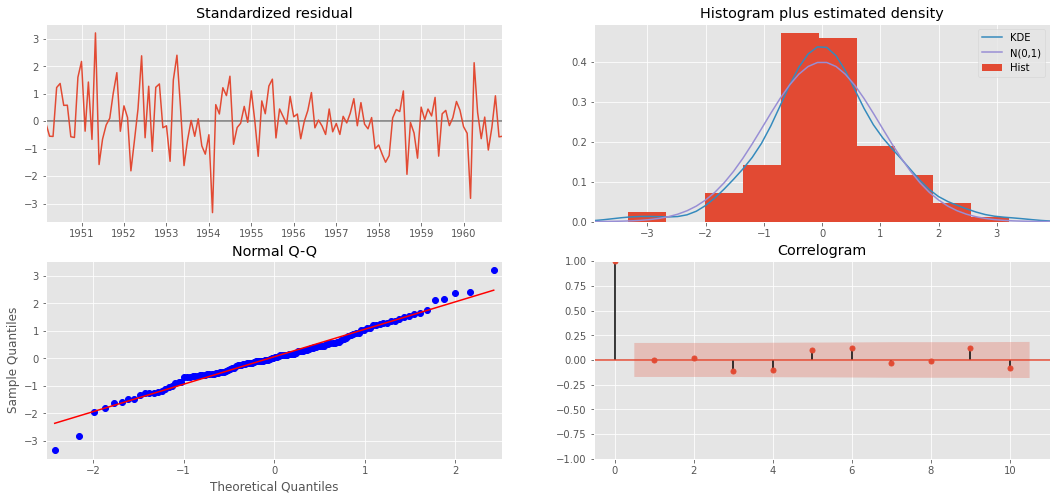

In [39]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()


*Model diagnostics suggests that the residuals of our model aren't correlated and are normally distributed with 0 mean. The qq-plot shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1) and the correlogram depicts that the time series residuals have low correlation with lagged versions of itself.*

# Steps for ARIMA implementation
**The general steps to implement an ARIMA model are –**

1) **Load the data**: *The first step for model building is of course to load the dataset.*
<br>
2) **Preprocessing**: *Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.* 
<br>
3) **Make series stationary**: *In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations*
<br>
4) **Determine d value**: *For making the series stationary, the number of times the difference operation was performed will be taken as the d value*
<br>
5) **Create ACF and PACF plots**: *This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model*
<br>
6)**Determine the p and q values**: *Read the values of p and q from the plots in the previous step.*
<br>
7) **Fit ARIMA model**: *Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model*
<br>
8) **Predict values on validation set**: *Predict the future values*
<br>
9) **Calculate RMSE**: *To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set. *

In [20]:
df=pd.read_csv('AirPassengers.csv')
df.head()

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

## What Auto ARIMA does?
*Before implementing ARIMA, the series has to be made stationary,and determine the values of p and q using the plots we discussed above. Auto ARIMA makes this task really simple for us as it eliminates steps 3 to 6 displayed in the ARIMA section.* 

# Steps for Auto-ARIMA implementation
**The general steps to implement an Auto-ARIMA model are –**

1) **Load the data**: *The first step for model building is of course to load the dataset.*
<br>
2) **Preprocessing**: *Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.* 
<br>
3) **Fit Auto ARIMA**: *Using the processed data and parameter values we calculated from the previous steps, fit the Auto-ARIMA model*
<br>
4) **Predict values on validation set**: *Predict the future values*
<br>
5) **Calculate RMSE**: *To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set.* 

In [21]:

  
# Import the library 
from pmdarima import auto_arima 
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(ts, start_p = 0, start_q = 0, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

ModuleNotFoundError: No module named 'pmdarima'

In [46]:
# Split data into train / test sets 
train = df.iloc[:len(df)-12] 
test = df.iloc[len(df)-12:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 0, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train['#Passengers'],  
                order = (0, 1, 1),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(2, 1, 0, 12)   Log Likelihood                -446.830
Date:                            Mon, 08 Feb 2021   AIC                            901.659
Time:                                    14:27:08   BIC                            912.776
Sample:                                         0   HQIC                           906.173
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2556      0.080     -3.190      0.001      -0.413      -0.099
ar.S.L12      -0.0962      0.090     -1.073      0.283      -0.272       0.080
ar.S.L24       0.1454      0.101      1.445      0.149      -0.052       0.343
sigma2       106.2408     15.243      6.970      0.000      76.364     136.117
===================================================================================
Ljung-Box (Q):                       42.14   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.38   Prob(JB):                         0.99
Heteroskedasticity (H):               1.63   Skew:                             0.01
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

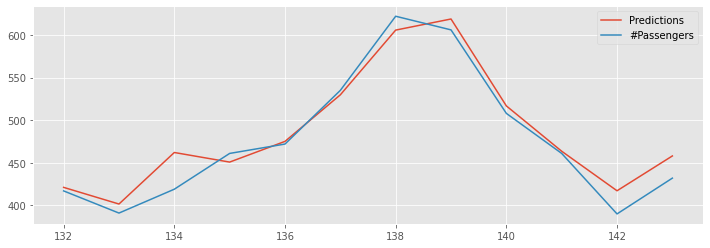

In [47]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['#Passengers'].plot(legend = True) 